# Parte 1 – Propensão de inadimplência

Implementar em contêiner o modelo propensão de inadimplência desenvolvido na disciplina de Estatística utilizando a linguagem R ou Python.

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from catboost import CatBoostClassifier

# Visualizando os dados

In [2]:
loan_default = pd.read_csv('../base/loan_default.csv')
loan_default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [3]:
loan_default.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co_applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
1,24932,2019,cf,Male,nopre,type3,p4,l1,nopc,nob/c,...,EQUI,765,EXP,45-54,to_inst,NaN,North,direct,1,NaN
2,25039,2019,cf,Male,nopre,type2,p3,l1,nopc,b/c,...,EQUI,880,EXP,35-44,to_inst,NaN,North,direct,1,NaN
3,25101,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EQUI,880,EXP,45-54,to_inst,NaN,central,direct,1,NaN
4,25110,2019,cf,Male,nopre,type3,p3,l1,nopc,nob/c,...,EQUI,768,EXP,45-54,not_inst,NaN,North,direct,1,NaN


In [4]:
loan_default.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,148670.0,99224.500000,42917.476598,24890.000000,62057.25000,99224.50000,136391.750000,1.735590e+05
year,148670.0,2019.000000,0.000000,2019.000000,2019.00000,2019.00000,2019.000000,2.019000e+03
loan_amount,148670.0,331117.743997,183909.310127,16500.000000,196500.00000,296500.00000,436500.000000,3.576500e+06
rate_of_interest,112231.0,4.045476,0.561391,0.000000,3.62500,3.99000,4.375000,8.000000e+00
Interest_rate_spread,112031.0,0.441656,0.513043,-3.638000,0.07600,0.39040,0.775400,3.357000e+00
Upfront_charges,109028.0,3224.996127,3251.121510,0.000000,581.49000,2596.45000,4812.500000,6.000000e+04
term,148629.0,335.136582,58.409084,96.000000,360.00000,360.00000,360.000000,3.600000e+02
property_value,133572.0,497893.465696,359935.315562,8000.000000,268000.00000,418000.00000,628000.000000,1.650800e+07
income,139520.0,6957.338876,6496.586382,0.000000,3720.00000,5760.00000,8520.000000,5.785800e+05
Credit_Score,148670.0,699.789103,115.875857,500.000000,599.00000,699.00000,800.000000,9.000000e+02


<Axes: >

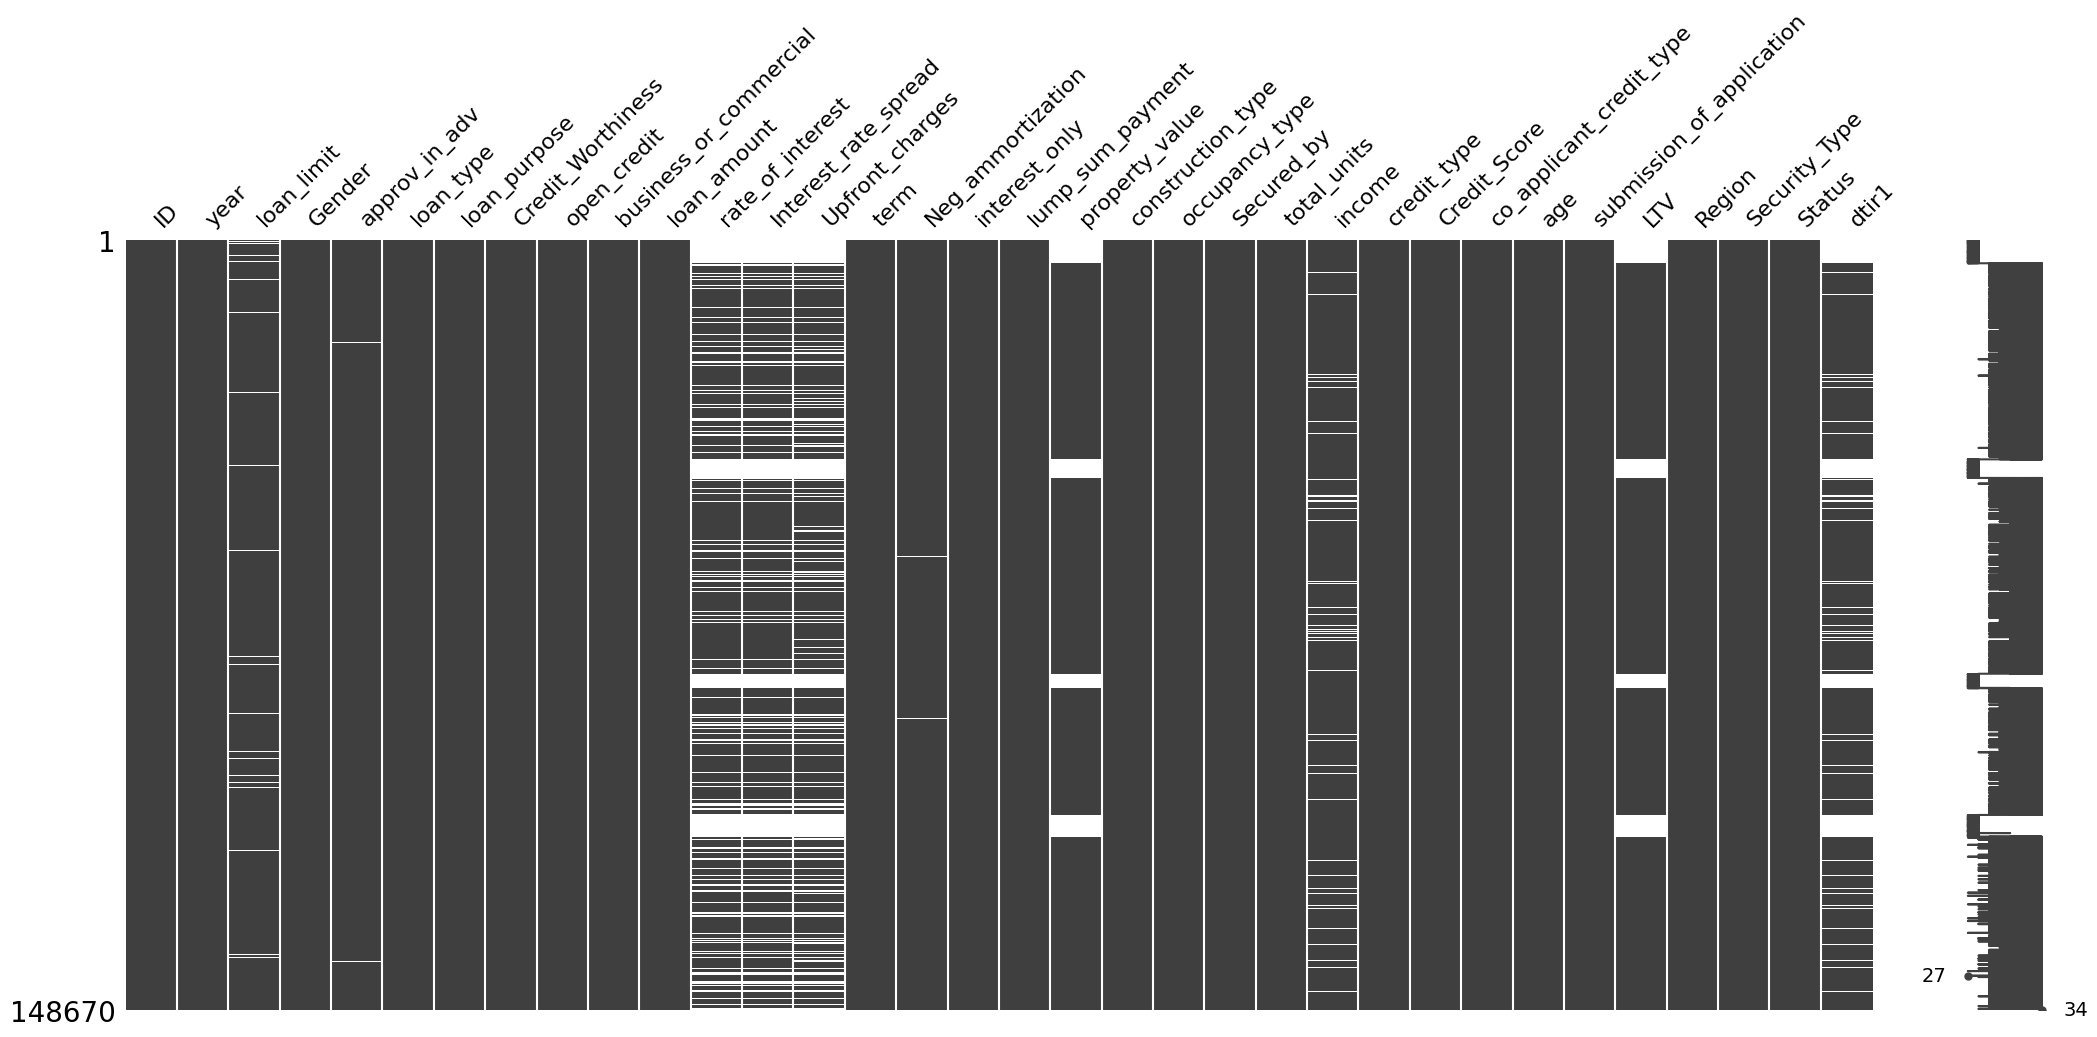

In [5]:
%matplotlib inline
msno.matrix(loan_default)

# Pré processamento

In [6]:
# Dropando colunas que não seráo utilizadas e limpando nulos
df = loan_default.drop(['ID', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges'], axis=1)
df = df.dropna(axis=0)

df.shape

(120526, 30)

In [7]:
cat_features = df.select_dtypes(include=['object']).columns.values
num_features = df.select_dtypes(exclude=['object']).columns.values

print('Quantity of category columns', len(cat_features))
print('Quantity of numerical columns', len(num_features))

Quantity of category columns 21
Quantity of numerical columns 9


In [8]:
X = df.drop('Status', axis=1)
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

# Treinando o modelo

In [9]:
cbc = CatBoostClassifier(
    learning_rate=0.05,
    n_estimators=50,
    depth=16,
    l2_leaf_reg=1e-4, 
    cat_features=cat_features,
    early_stopping_rounds=10
)

cbc.fit(X_train, y_train)

0:	learn: 0.6450865	total: 2.02s	remaining: 1m 39s
1:	learn: 0.6093533	total: 3.93s	remaining: 1m 34s
2:	learn: 0.5740010	total: 5.87s	remaining: 1m 32s
3:	learn: 0.5465285	total: 7.68s	remaining: 1m 28s
4:	learn: 0.5267784	total: 7.7s	remaining: 1m 9s
5:	learn: 0.5026199	total: 9.62s	remaining: 1m 10s
6:	learn: 0.4810951	total: 11.5s	remaining: 1m 10s
7:	learn: 0.4630666	total: 13.6s	remaining: 1m 11s
8:	learn: 0.4495548	total: 13.6s	remaining: 1m 2s
9:	learn: 0.4386735	total: 13.7s	remaining: 54.7s
10:	learn: 0.4267670	total: 15.6s	remaining: 55.4s
11:	learn: 0.4182284	total: 15.7s	remaining: 49.6s
12:	learn: 0.4082171	total: 17.7s	remaining: 50.4s
13:	learn: 0.3969311	total: 19.6s	remaining: 50.5s
14:	learn: 0.3911641	total: 19.7s	remaining: 46s
15:	learn: 0.3814086	total: 21.6s	remaining: 45.9s
16:	learn: 0.3739435	total: 23.6s	remaining: 45.9s
17:	learn: 0.3654381	total: 25.6s	remaining: 45.5s
18:	learn: 0.3608570	total: 27.6s	remaining: 45s
19:	learn: 0.3538805	total: 29.5s	remai

Training has stopped (degenerate solution on iteration 49, probably too small l2-regularization, try to increase it)


In [10]:
most_importance_features = pd.DataFrame(cbc.get_feature_importance(), index=X.columns.values, columns=['importance']).sort_values('importance', ascending=False)
selected_features = most_importance_features.head(10).index.values
selected_features

array(['occupancy_type', 'co_applicant_credit_type', 'Credit_Score',
       'LTV', 'loan_purpose', 'dtir1', 'property_value',
       'submission_of_application', 'approv_in_adv', 'income'],
      dtype=object)

# Treinando o modelo final com colunas reduzidas

In [11]:
X_selected = df[selected_features]
y_selected = df['Status']
cat_features_selected = df[selected_features].select_dtypes('object').columns.values

X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, train_size=0.8, shuffle=True, random_state=42)

In [12]:
cbc = CatBoostClassifier(
    learning_rate=0.05,
    n_estimators=10,
    depth=16,
    l2_leaf_reg=1e-4, 
    cat_features=cat_features_selected,
    early_stopping_rounds=10
)

cbc.fit(X_train_selected, y_train_selected)

0:	learn: 0.6666814	total: 608ms	remaining: 5.47s
1:	learn: 0.6437139	total: 620ms	remaining: 2.48s
2:	learn: 0.6219444	total: 1.29s	remaining: 3.01s
3:	learn: 0.6017564	total: 1.95s	remaining: 2.93s
4:	learn: 0.5834576	total: 2.59s	remaining: 2.59s
5:	learn: 0.5666123	total: 3.26s	remaining: 2.17s
6:	learn: 0.5512157	total: 3.89s	remaining: 1.67s
7:	learn: 0.5369542	total: 4.5s	remaining: 1.13s
8:	learn: 0.5240064	total: 5.21s	remaining: 579ms
9:	learn: 0.5129715	total: 5.22s	remaining: 0us


# Avaliando o modelo

In [13]:
print('Train score', cbc.score(X_train_selected, y_train_selected))
print('Test score', cbc.score(X_test_selected, y_test_selected))

Train score 0.8580170089193113
Test score 0.852692275781963


# Salvando modelo

In [14]:
filename = 'docker/default_propensity_model.pkl'
pickle.dump(cbc, open(filename, 'wb'))

In [16]:
cbc.predict(['pr', 'EXP', 736, 80.0245098, 'p3', 49.0, 408000.0, 'to_inst',
       'nopre', 5880.0])

0

In [21]:
# Guardar os dados para teste da API

request_sample = X_test_selected.iloc[0].to_json()

with open("docker/request_sample.json", "w") as file:
    file.write(request_sample)